In [1]:
from whstudy import WorldIndicators
from sklearn.manifold import TSNE
from ProjectionCorrelation import score_projections
from Orange.data.pandas_compat import table_from_frame
from Orange.data import ContinuousVariable
from Orange.preprocess import Normalize
import matplotlib.pyplot as plt

import random

### Get data from mongo database

In [6]:
handle = WorldIndicators('main', 'biolab')
country_codes = [code for code, _ in handle.countries()]
indicator_codes = ['EN.ATM.GHGT.KT.CE', 'EG.ELC.ACCS.ZS', 'AG.LND.FRST.ZS', 'GC.DOD.TOTL.GD.ZS',
                   'EN.POP.SLUM.UR.ZS', 'SL.UEM.TOTL.ZS', 'AG.YLD.CREL.KG', 'SH.STA.TRAF.P5']

df = handle.data(country_codes, indicator_codes, range(2000,2020)).fillna(0)

reference = df.iloc[:, :3]
overlay = df.iloc[:, 3:]

### Split data to reference and overlay and perform t-SNE and scoring

In [7]:
ref_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(reference.to_numpy())

tSNE_X = ContinuousVariable("t-SNE-x")
tSNE_Y = ContinuousVariable("t-SNE-y")

overlay_table = table_from_frame(overlay)
ref_table = table_from_frame(reference)
ref_table = ref_table.add_column(tSNE_X, ref_tsne[:, 0], to_metas=True)
ref_table = ref_table.add_column(tSNE_Y, ref_tsne[:, 1], to_metas=True)

scores = score_projections(ref_table, tSNE_X, tSNE_Y, overlay_table)


### Draw visualization of good and bad features

2003-EN.ATM.GHGT.KT.CE:0.0006027751964721654


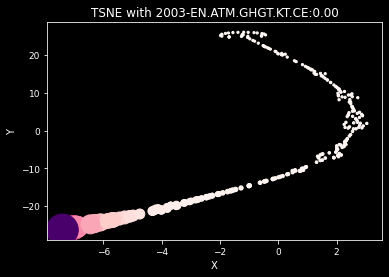

2004-EN.ATM.GHGT.KT.CE:0.0006404453228669136


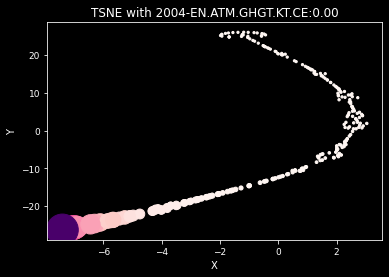

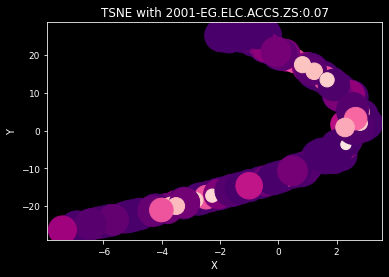

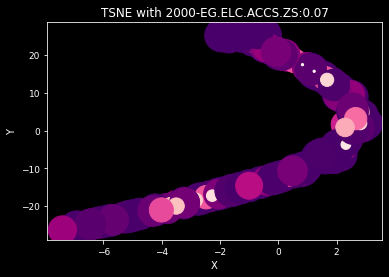

In [9]:
def plot_score(f_name, f_score, arr):
    values = 5 + 1000 * arr[:, f_name].X_df.to_numpy()
    plt.scatter(ref_tsne[:, 0], ref_tsne[:, 1], s=values, c=values, cmap='RdPu')

    plt.title(f"TSNE with {f_name}:{f_score:.2f}")
    plt.xlabel("X", fontsize=10)
    plt.ylabel("Y", fontsize=10)
    plt.tick_params(axis="both", which='major', labelsize=9)
    plt.show()


norm = Normalize(norm_type=Normalize.NormalizeBySpan, zero_based=True)
out = norm(overlay_table)

# Find best score and display

sorted_scores = sorted(scores, key=lambda tup: tup[1])

plt.style.use('dark_background')

for (name, score) in sorted_scores[:2]:
    print(f"{name}:{score}")
    plot_score(name, score, out)

for (name, score) in sorted_scores[-2:]:
    plot_score(name, score, out)